In [3]:
import talib as ta
import pandas as pd
import talib
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Function to get historical price data
def get_price_data(ticker, start_date, end_date, intervalOverride = '1d'):
   data = yf.download(ticker, start=start_date, end=end_date, interval=intervalOverride, keepna=False)
   return data

In [231]:
ticker = 'NVDA'
start_date = '2025-02-25'
end_date = '2025-07-01'
applStock = get_price_data(ticker, start_date, end_date, '1d')

C:\Users\alexi\AppData\Local\Temp\ipykernel_3120\989039489.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, interval=intervalOverride, keepna=False)
[*********************100%***********************]  1 of 1 completed


In [270]:
def stockSellStrategy(price_data, ticker, startDate):
    size = price_data['High'].size
    close = np.zeros(size)
    high = np.zeros(size)
    low = np.zeros(size)
    signal = np.zeros(size)
    position = np.zeros(size)
    smaPeriod = 50
    totalCash = 0
    wantsToSell = True
    numberTrades = 0
    numberProfitableTrades = 0
    firstBuy = True
    initial = 0
    stockAmount = 1
    
    for x in range(size):
       high[x]=price_data['High'].to_numpy()[x][0]
       low[x]=price_data['Low'].to_numpy()[x][0]
       close[x]=price_data['Close'].to_numpy()[x][0]

    sarResult = talib.SAR(high, low, acceleration=0.02, maximum=0.2)
    SMA = talib.SMA(close, timeperiod=smaPeriod)


    price_data['SMA'] = SMA
    price_data['SAR'] = sarResult
    
    price_data = price_data.loc[startDate:]
    price_data = price_data.loc[:'2025-07-01']

    size = price_data['High'].size
    close = np.zeros(size)
    position = np.zeros(size)
    SMA = np.zeros(size)
    sarResult = np.zeros(size)
 


    for x in range(size):
       close[x]=price_data['Close'].to_numpy()[x][0]
       SMA[x]=price_data['SMA'].iloc[x]
       sarResult[x]=price_data['SAR'].iloc[x]
        
    SMADirection = np.sign(np.diff(SMA))


    #stock price is above SMA
    #SMA is sloping upwards
    #PSAR flips below the price -> buy 
    #PSAR flips above the price ->sell
    for x in range(size):
        if x == 0:
            continue
            
        if wantsToSell:
            if x < size-1 and close[x] < SMA[x] and SMADirection[x] < 0 and sarResult[x-1] < close[x-1] and sarResult[x] >= close[x]:
                wantsToSell = False;
                sellPosition = close[x]
                position[x] = -1
                print('at ' + str(price_data.index[x]) + ' We sell position of price ' + str(close[x]))
                totalCash = stockAmount*close[x]
        

        elif sarResult[x-1] < close[x-1] and sarResult[x] >= close[x] or x == size -1:
                position[x] = 1
                wantsToSell = True
                numberTrades+=1
                print('at ' + str(price_data.index[x]) + ' We buy position of price ' + str(close[x]))
                margin = sellPosition - close[x]
                print('we do a margin of ' + str(margin))
                sellPosition = 0
                stockAmount = totalCash/close[x]
                if margin > 0:
                    numberProfitableTrades+=1

    
    price_data['SAR'] = sarResult
    price_data['SMA'] = SMA
    price_data['Position'] = position;
    profit = 0
    if(totalCash != 0):
        profit = 100*(totalCash / initial - 1)
    buyHold = 100*(price_data['Close'].iloc[size-1]/price_data['Close'].iloc[0] - 1)
    print(' Profit :', profit, '%')
    print('Acheter action Profit: ', buyHold, '%')
    
    
    plot_strategy(price_data, str(smaPeriod), ticker)
    print(totalCash)


#https://blog.quantinsti.com/parabolic-sar/


In [5]:
def forexSellStrat(price_data, startDate, endDate):
    size = price_data['High'].size
    high = np.zeros(size)
    low = np.zeros(size)
    signal = np.zeros(size)
    position = np.zeros(size)
    smaPeriod = 60
    stopLoss = 0.0015
    profitStop = 0.0010
    initial = 0
    buyPosition = 0
    totalCash = 0
    wantsToSell = True
    numberTrades = 0
    numberProfitableTrades = 0
    stockAmount = 1
    first =True
    nbStop = 0
    
    for x in range(size):
       low[x]=price_data['Low'].to_numpy()[x][0]
       high[x]=price_data['High'].to_numpy()[x][0]

    smaBuy = talib.SMA(high, timeperiod=smaPeriod)
    smaSell = talib.SMA(low, timeperiod=smaPeriod)

    price_data['SMABuy'] = smaBuy
    price_data['SMASell'] = smaSell
    
    price_data = price_data.loc[startDate:]
    price_data = price_data.loc[:endDate]

    size = price_data['High'].size
    high = np.zeros(size)
    low = np.zeros(size)
    signal = np.zeros(size)
    position = np.zeros(size)
    smaBuy = np.zeros(size)
    smaSell = np.zeros(size)
    

    for x in range(size):
       high[x]=price_data['High'].to_numpy()[x][0]
       low[x]=price_data['Low'].to_numpy()[x][0]
       smaBuy[x]=price_data['SMABuy'].iloc[x]
       smaSell[x]=price_data['SMASell'].iloc[x]

    
    #we buy the 'High' and sell the 'Low' (ask and bid)

    sarResult = talib.SAR(high, low, acceleration=0.02, maximum=0.2)
    sarDirection = np.sign(np.diff(sarResult))
    smaBuyDir =  np.sign(np.diff(smaBuy))
    smaSellDir =  np.sign(np.diff(smaSell))


    for x in range(size):
        if x == 0:
            continue
            
        if wantsToSell:
            if x < size-1 and low[x] < smaSell[x] and smaSellDir[x] < 0 and sarResult[x-1] < low[x-1] and sarResult[x] >= low[x]:
                wantsToSell = False;
                sellPosition = low[x]
                position[x] = -1
                print('at ' + str(price_data.index[x]) + ' We sell position of price ' + str(low[x]))
                totalCash = stockAmount*low[x]
        

        elif sarResult[x-1] < high[x-1] and sarResult[x] >= high[x] or x == size -1:
                position[x] = 1
                wantsToSell = True
                numberTrades+=1
                print('at ' + str(price_data.index[x]) + ' We buy position of price ' + str(high[x]))
                margin = sellPosition - high[x]
                print('we do a margin of ' + str(margin))
                sellPosition = 0
                stockAmount = totalCash/high[x]
                if margin > 0:
                    numberProfitableTrades+=1
        elif sellPosition - high[x] >= stopLoss: #stoploss
                nbStop+=1
                position[x] = 1
                wantsToSell = True
                numberTrades+=1
                print('at ' + str(price_data.index[x]) + 'STOP LOSS We buy position of price ' + str(high[x]))
                margin = sellPosition - high[x]
                print('we do a margin of ' + str(margin))
                sellPosition = 0
                stockAmount = totalCash/high[x]
                if margin > 0:
                    numberProfitableTrades+=1
     
    price_data['Signal'] = signal
    price_data['SAR'] = sarResult
    price_data['Position'] = position;


    #price_data = price_data.loc['2025-06-01':]
    #price_data = price_data.loc[:'2025-06-05']


    buyHold = 100*(price_data['Low'].iloc[size-1]/price_data['High'].iloc[0] - 1)
    print(' Cash :', totalCash, ' stock amount ', stockAmount, ' wants to sell? ', wantsToSell)
    print('Acheter action Profit: ', buyHold, '%')
    print('profitable trades' + str(numberProfitableTrades) +' total '  + str(numberTrades))
    print('stop losses ', nbStop)

    plot_forex(price_data, str(smaPeriod), 'EUR/USD Sell SAR' )
    #print(totalCash+buyPosition)
    

In [6]:
def plot_strategy(data, smaPeriod, ticker):
   plt.figure(figsize=(12, 6))
   plt.plot(data['Close'], label='Close Price', alpha=0.5)
   plt.scatter(data[data['Position'] == 1].index, data['Close'][data['Position'] == 1], marker='^', color='g', label='Buy Signal')
   plt.scatter(data[data['Position'] == -1].index, data['Close'][data['Position'] == -1], marker='v', color='r', label='Sell Signal')
   plt.plot(data['SAR'], label='Parabolic SAR', linestyle='dashed', alpha=0.5)
   plt.plot(data['SMA'], label='SMA '+ smaPeriod, linestyle='dashed', alpha=0.5)
   plt.title('Parabolic ' + ticker)
   plt.xlabel('Date')
   plt.ylabel('Price')
   plt.legend()
   plt.show()

In [7]:
def stockStrategy(price_data, ticker, startDate):
    size = price_data['High'].size
    close = np.zeros(size)
    high = np.zeros(size)
    low = np.zeros(size)
    signal = np.zeros(size)
    position = np.zeros(size)
    smaPeriod = 15
    hasBought = False
    hasSold = False
    numberTrades = 0
    numberProfitableTrades = 0
    initial = 0
    stockAmount = 1
    totalCash = 0
    
    for x in range(size):
       high[x]=price_data['High'].to_numpy()[x][0]
       low[x]=price_data['Low'].to_numpy()[x][0]
       close[x]=price_data['Close'].to_numpy()[x][0]

    sarResult = talib.SAR(high, low, acceleration=0.02, maximum=0.2)
    SMA = talib.SMA(close, timeperiod=smaPeriod)


    price_data['SMA'] = SMA
    price_data['SAR'] = sarResult
    
    price_data = price_data.loc[startDate:]
    price_data = price_data.loc[:'2025-07-01']

    size = price_data['High'].size
    close = np.zeros(size)
    position = np.zeros(size)
    SMA = np.zeros(size)
    sarResult = np.zeros(size)
 


    for x in range(size):
       close[x]=price_data['Close'].to_numpy()[x][0]
       SMA[x]=price_data['SMA'].iloc[x]
       sarResult[x]=price_data['SAR'].iloc[x]
        
    SMADirection = np.sign(np.diff(SMA))
    sarDirection = np.sign(np.diff(sarResult))
    
    #stock price is above SMA
    #SMA is sloping upwards
    #PSAR flips below the price -> buy 
    #PSAR flips above the price ->sell
    for x in range(size):
        if x == 0 or x >= size-1:  
            continue
        
        if hasBought: #evaluating exit out buy action
            if sarDirection[x] < 0 or x == size -1:
                position[x] = -1
                hasBought = False
                numberTrades+=1
                print('at ' + str(price_data.index[x]) + ' We sell position of price ' + str(close[x]))
                margin = close[x] - buyPosition
                print('we do a margin of ' + str(margin))
                totalCash += close[x]
                buyPosition = 0
                if margin > 0:
                    numberProfitableTrades+=1
        if hasSold: #evaluating exit out of sell action 
            if sarDirection[x] > 0 or x == size -1:
                position[x] = 1
                hasSold = False
                numberTrades+=1
                print('at ' + str(price_data.index[x]) + ' We buy position of price ' + str(close[x]))
                margin = sellPosition - close[x]
                totalCash -= close[x]
                print('we do a margin of ' + str(margin))
                sellPosition = 0
                if margin > 0:
                    numberProfitableTrades+=1
        if SMADirection[x] > 0: #wants to buy
            if x < size-1 and close[x] > SMA[x] and sarResult[x-1] >= close[x-1] and sarResult[x] < close[x]:
                hasBought = True;
                buyPosition = close[x]
                position[x] = 1
                print('at ' + str(price_data.index[x]) + ' We buy position of price ' + str(close[x]))

        elif SMADirection[x] < 0: #wants to sell
            if x < size-1 and close[x] < SMA[x] and sarResult[x-1] < close[x-1] and sarResult[x] >= close[x]:
                hasSold = True;
                sellPosition = close[x]
                position[x] = -1
                print('at ' + str(price_data.index[x]) + ' We sell position of price ' + str(close[x]))
                
    price_data['SAR'] = sarResult
    price_data['SMA'] = SMA
    price_data['Position'] = position;

    buyHold = 100*(price_data['Close'].iloc[size-1]/price_data['Close'].iloc[0] - 1)

    
    
    print('Acheter action Profit: ', buyHold, '%')
    
    print('profitable trades' + str(numberProfitableTrades) +' total '  + str(numberTrades) + ' total cash ', totalCash)

    plot_strategy(price_data, str(smaPeriod), ticker)



#https://blog.quantinsti.com/parabolic-sar/

    

C:\Users\alexi\AppData\Local\Temp\ipykernel_13876\989039489.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, interval=intervalOverride, keepna=False)
[*********************100%***********************]  1 of 1 completed


at 2025-06-05 00:00:00 We buy position of price 139.98028564453125
Acheter action Profit:  Ticker
NVDA    15.010167
dtype: float64 %
profitable trades0 total 0 total cash  0


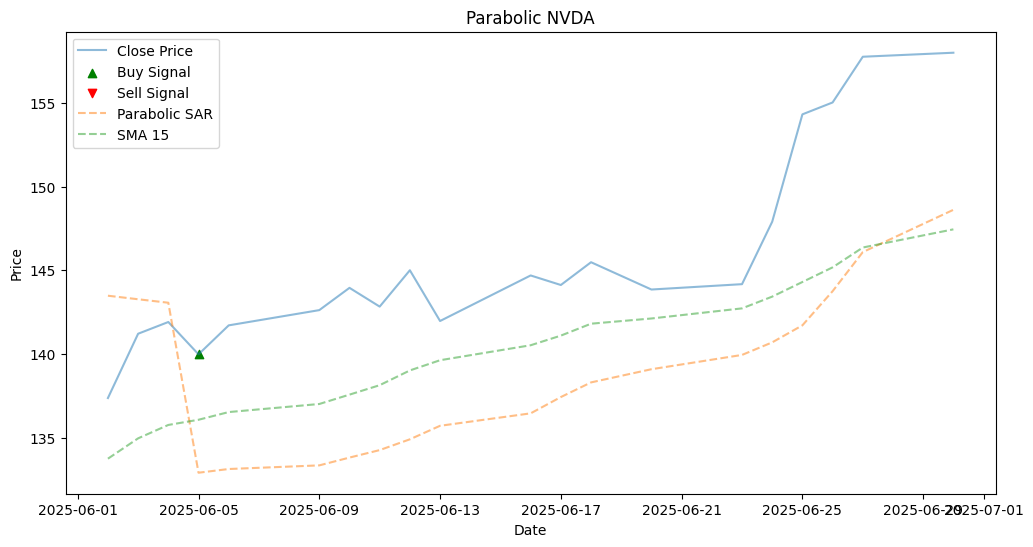

at 2025-06-05 00:00:00 We buy position of price 139.98028564453125
Acheter action Profit:  Ticker
NVDA    41.565252
dtype: float64 %
profitable trades0 total 0 total cash  0


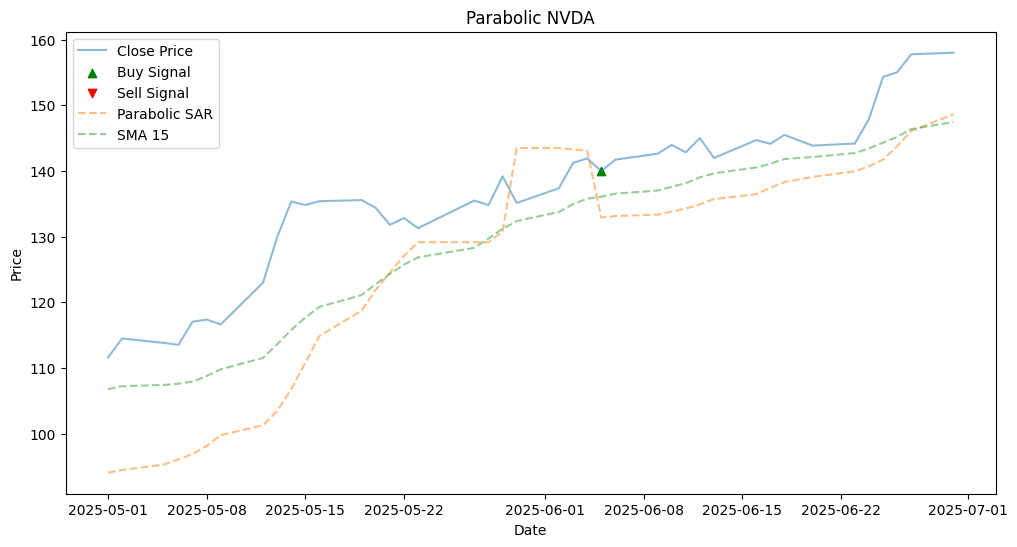

C:\Users\alexi\AppData\Local\Temp\ipykernel_13876\989039489.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, interval=intervalOverride, keepna=False)
[*********************100%***********************]  1 of 1 completed


at 2025-05-22 00:00:00 We sell position of price 201.36000061035156
at 2025-06-24 00:00:00 We buy position of price 200.3000030517578
we do a margin of 1.05999755859375
Acheter action Profit:  Ticker
AAPL   -3.694429
dtype: float64 %
profitable trades1 total 1 total cash  -200.3000030517578


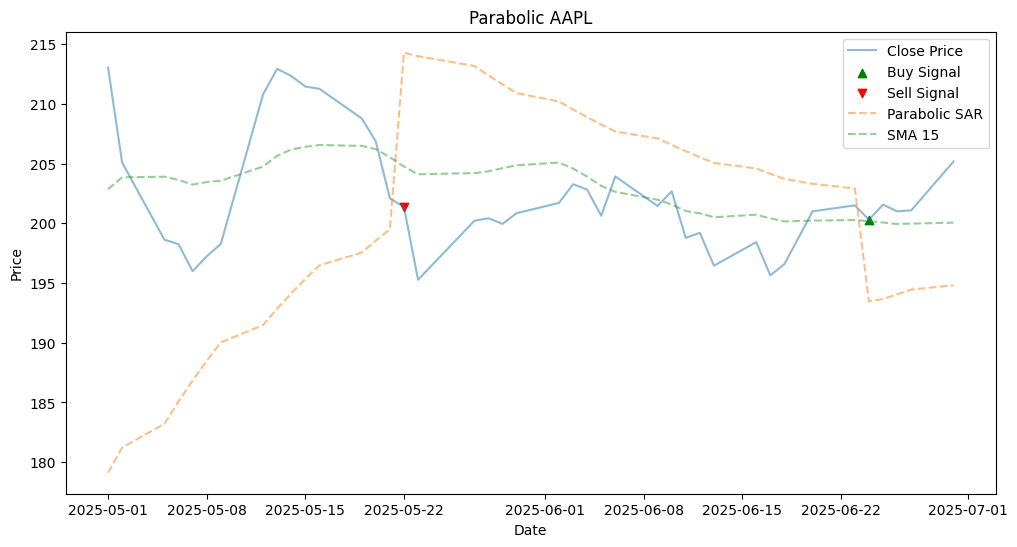

Acheter action Profit:  Ticker
AAPL    1.720377
dtype: float64 %
profitable trades0 total 0 total cash  0


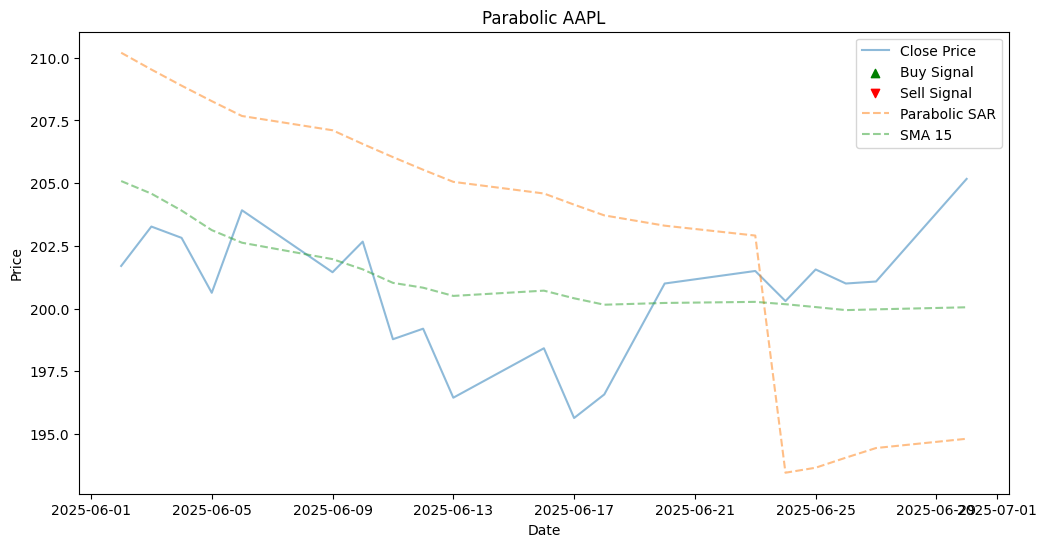

In [8]:
startTrade2month = '2025-05-01'
startTrade1month = '2025-06-01'
ticker = 'NVDA'
start_date = '2025-02-25'
end_date = '2025-07-01'

stockNVDA = get_price_data(ticker, start_date, end_date, '1d')
stockStrategy(stockNVDA, ticker, startTrade1month)
stockStrategy(stockNVDA, ticker, startTrade2month)

ticker = 'AAPL'
start_date = '2025-02-25'
end_date = '2025-07-01'

applStock = get_price_data(ticker, start_date, end_date, '1d')
stockStrategy(applStock, ticker, startTrade2month)
stockStrategy(applStock, ticker, startTrade1month)




In [11]:
def plot_forex(data, smaPeriod, ticker):
   plt.figure(figsize=(12, 6))
   plt.plot(data['High'], label='Bid', alpha=0.5)
   plt.plot(data['Low'], label='Ask', alpha=0.5)

   plt.plot(data['SAR'], label='Parabolic SAR', linestyle='dashed', alpha=0.5)
   plt.plot(data['SMABuy'], label='SMA Buy '+ smaPeriod, linestyle='dashed', alpha=0.5)
   plt.plot(data['SMASell'], label='SMA Sell '+ smaPeriod, linestyle='dashed', alpha=0.5)
   plt.scatter(data[data['Position'] == 1].index, data['High'][data['Position'] == 1], marker='*', color='g', label='Buy')
   plt.scatter(data[data['Position'] == -1].index, data['Low'][data['Position'] == -1], marker='*', color='r', label='Sell')


    
   plt.title('Parabolic ' + ticker)
   plt.xlabel('Date')
   plt.ylabel('Price')
   plt.legend()
   plt.show()

In [15]:
def forexStrat(price_data, startDate, endDate):
    size = price_data['High'].size
    high = np.zeros(size)
    low = np.zeros(size)
    signal = np.zeros(size)
    position = np.zeros(size)
    smaPeriod = 60
    stopLoss = 0.0015
    profitStop = 0.0010
    initial = 0
    buyPosition = 0
    totalCash = 0
    wantsToBuy = False
    wantsToSell = False
    hasBought = False
    hasSold = False
    
    firstBuy = True
    numberTrades = 0
    numberProfitableTrades = 0
    stockAmount = 1
    nbStop = 0
    
    for x in range(size):
       low[x]=price_data['Low'].to_numpy()[x][0]
       high[x]=price_data['High'].to_numpy()[x][0]

    smaBuy = talib.SMA(high, timeperiod=smaPeriod)
    smaSell = talib.SMA(low, timeperiod=smaPeriod)

    price_data['SMABuy'] = smaBuy
    price_data['SMASell'] = smaSell
    
    price_data = price_data.loc[startDate:]
    price_data = price_data.loc[:endDate]

    size = price_data['High'].size
    high = np.zeros(size)
    low = np.zeros(size)
    signal = np.zeros(size)
    position = np.zeros(size)
    smaBuy = np.zeros(size)
    smaSell = np.zeros(size)
    

    for x in range(size):
       high[x]=price_data['High'].to_numpy()[x][0]
       low[x]=price_data['Low'].to_numpy()[x][0]
       smaBuy[x]=price_data['SMABuy'].iloc[x]
       smaSell[x]=price_data['SMASell'].iloc[x]

    
    #we buy the 'High' and sell the 'Low' (ask and bid)

    sarResult = talib.SAR(high, low, acceleration=0.02, maximum=0.2)
    sarDirection = np.sign(np.diff(sarResult))
    smaBuyDir =  np.sign(np.diff(smaBuy))
    smaSellDir =  np.sign(np.diff(smaSell))


    for x in range(size):
        if x == 0 or  x == size -1:
            continue
        if hasBought:
            if sarDirection[x] <= 0 or x == size -1:
                position[x] = -1
                hasBought = False
                totalCash += low[x]
                numberTrades+=1
                print('at ' + str(price_data.index[x]) + ' We sell position of price ' + str(low[x]))
                margin = low[x] - buyPosition
                print('we do a margin of ' + str(margin))
                buyPosition = 0
                totalCash = stockAmount*low[x]
                if margin > 0:
                    numberProfitableTrades+=1
            elif buyPosition - low[x] >= stopLoss or low[x] - buyPosition >= 0.001: #stop loss
                nbStop+=1
                position[x] = -1
                hasBought = False
                totalCash += low[x]
                numberTrades+=1
                print('at ' + str(price_data.index[x]) + ' STOP LOSS: We sell position of price ' + str(low[x]))
                margin = low[x] - buyPosition
                print('we do a margin of ' + str(margin))
                buyPosition = 0
                totalCash = stockAmount*low[x]
                if margin > 0:
                    numberProfitableTrades+=1

        if hasSold:
            if sarDirection[x] >= 0 or x == size -1:
                position[x] = 1
                hasSold = False 
                numberTrades+=1
                print('at ' + str(price_data.index[x]) + ' We buy position of price ' + str(high[x]))
                margin = sellPosition - high[x]
                print('we do a margin of ' + str(margin))
                sellPosition = 0
                stockAmount = totalCash/high[x]
                if margin > 0:
                    numberProfitableTrades+=1

            elif high[x] - sellPosition >= stopLoss or sellPosition - low[x] >= 0.001: #stoploss
                nbStop+=1
                position[x] = 1
                hasSold = False
                numberTrades+=1
                print('at ' + str(price_data.index[x]) + 'STOP LOSS We buy position of price ' + str(high[x]))
                margin = sellPosition - high[x]
                print('we do a margin of ' + str(margin))
                sellPosition = 0
                stockAmount = totalCash/high[x]
                if margin > 0:
                    numberProfitableTrades+=1
  
        elif smaBuyDir[x] > 0: #wants to buy
            if x < size-1 and high[x] > smaBuy[x] and sarResult[x-1] >= high[x-1] and sarResult[x] < high[x]:
                hasBought = True;
                buyPosition = high[x]
                position[x] = 1
                print('at ' + str(price_data.index[x]) + ' We buy position of price ' + str(high[x]))
                stockAmount = totalCash/high[x]

        elif smaSellDir[x] < 0: #wants to sell
            if x < size-1 and low[x] < smaSell[x] and sarResult[x-1] < low[x-1] and sarResult[x] >= low[x]:
                hasSold = True;
                sellPosition = low[x]
                position[x] = -1
                print('at ' + str(price_data.index[x]) + ' We sell position of price ' + str(low[x]))
                totalCash = stockAmount*low[x]
        
        
            
    price_data['Signal'] = signal
    price_data['SAR'] = sarResult
    price_data['Position'] = position;


    #price_data = price_data.loc['2025-06-01':]
    #price_data = price_data.loc[:'2025-06-05']

    profit = 100*(totalCash / initial - 1)
    buyHold = 100*(price_data['Low'].iloc[size-1]/price_data['High'].iloc[0] - 1)
    print(' Profit :', profit, '%')
    print('Acheter action Profit: ', buyHold, '%')
    print('profitable trades' + str(numberProfitableTrades) +' total '  + str(numberTrades) + ' profit: ' +str(profit))
    print('stop losses ', nbStop)
    plot_forex(price_data, str(smaPeriod), 'EUR/USD SAR' )
    #print(totalCash+buyPosition)
    


In [16]:
ticker = 'EURUSD=X'
start_date = '2025-05-25'
end_date = '2025-07-01'
euroUsd = get_price_data(ticker, start_date, end_date, '5m')

C:\Users\alexi\AppData\Local\Temp\ipykernel_13876\989039489.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, interval=intervalOverride, keepna=False)
[*********************100%***********************]  1 of 1 completed


at 2025-06-10 04:15:00+00:00 We sell position of price 1.140380859375
at 2025-06-10 05:00:00+00:00 We buy position of price 1.140380859375
we do a margin of 0.0
at 2025-06-10 05:45:00+00:00 We sell position of price 1.140380859375
at 2025-06-10 06:20:00+00:00 We buy position of price 1.1418131589889526
we do a margin of -0.0014322996139526367
at 2025-06-10 10:25:00+00:00 We buy position of price 1.1424654722213745
at 2025-06-10 12:00:00+00:00 STOP LOSS: We sell position of price 1.1435105800628662
we do a margin of 0.0010451078414916992
at 2025-06-10 12:45:00+00:00 We buy position of price 1.1437721252441406
at 2025-06-10 14:05:00+00:00 We sell position of price 1.144164800643921
we do a margin of 0.00039267539978027344
at 2025-06-10 17:20:00+00:00 We sell position of price 1.1420739889144897
at 2025-06-10 17:40:00+00:00 We buy position of price 1.142987847328186
we do a margin of -0.0009138584136962891
at 2025-06-10 18:15:00+00:00 We sell position of price 1.1422044038772583
at 2025-0

C:\Users\alexi\AppData\Local\Temp\ipykernel_13876\1012626721.py:143: RuntimeWarning: divide by zero encountered in scalar divide
  profit = 100*(totalCash / initial - 1)


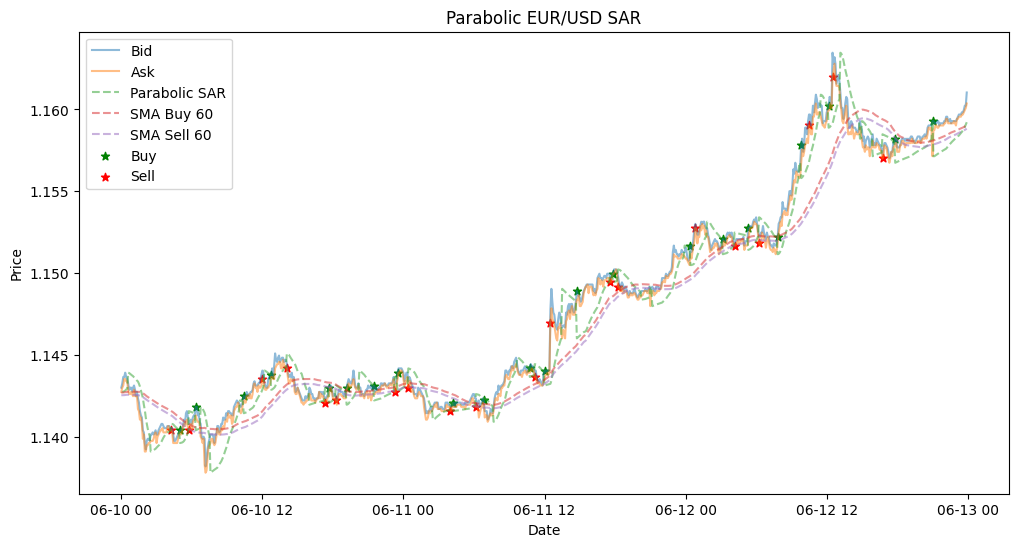

at 2025-06-02 09:00:00+00:00 We buy position of price 1.1428571939468384
at 2025-06-02 09:55:00+00:00 We sell position of price 1.1428571939468384
we do a margin of 0.0
at 2025-06-02 11:10:00+00:00 We buy position of price 1.1425960063934326
at 2025-06-02 11:35:00+00:00 We sell position of price 1.1419435739517212
we do a margin of -0.0006524324417114258
at 2025-06-02 13:00:00+00:00 We sell position of price 1.1419435739517212
at 2025-06-02 13:25:00+00:00STOP LOSS We buy position of price 1.1416828632354736
we do a margin of 0.0002607107162475586
at 2025-06-02 21:25:00+00:00 We buy position of price 1.1445575952529907
at 2025-06-02 23:45:00+00:00 STOP LOSS: We sell position of price 1.1456066370010376
we do a margin of 0.001049041748046875
at 2025-06-03 01:50:00+00:00 We sell position of price 1.1432491540908813
at 2025-06-03 02:40:00+00:00STOP LOSS We buy position of price 1.1425960063934326
we do a margin of 0.0006531476974487305
at 2025-06-03 03:25:00+00:00 We sell position of price

C:\Users\alexi\AppData\Local\Temp\ipykernel_13876\1012626721.py:143: RuntimeWarning: invalid value encountered in scalar divide
  profit = 100*(totalCash / initial - 1)


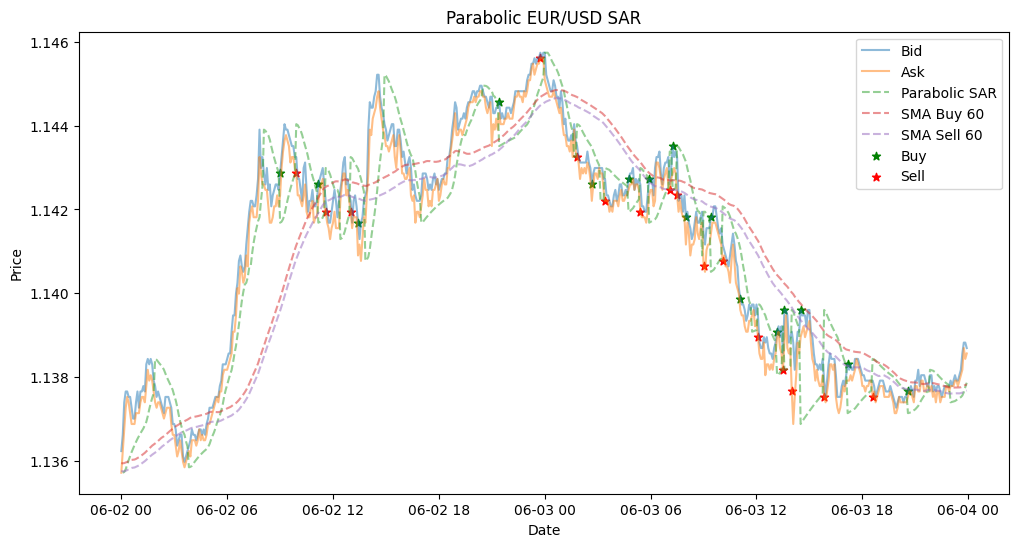

at 2025-06-01 23:55:00+00:00 We sell position of price 1.1354604959487915
at 2025-06-02 00:05:00+00:00 We buy position of price 1.1366219520568848
we do a margin of -0.0011614561080932617
at 2025-06-02 09:00:00+00:00 We buy position of price 1.1428571939468384
at 2025-06-02 09:55:00+00:00 We sell position of price 1.1428571939468384
we do a margin of 0.0
at 2025-06-02 11:10:00+00:00 We buy position of price 1.1425960063934326
at 2025-06-02 11:35:00+00:00 We sell position of price 1.1419435739517212
we do a margin of -0.0006524324417114258
at 2025-06-02 13:00:00+00:00 We sell position of price 1.1419435739517212
at 2025-06-02 13:25:00+00:00STOP LOSS We buy position of price 1.1416828632354736
we do a margin of 0.0002607107162475586
at 2025-06-02 21:25:00+00:00 We buy position of price 1.1445575952529907
at 2025-06-02 23:45:00+00:00 STOP LOSS: We sell position of price 1.1456066370010376
we do a margin of 0.001049041748046875
at 2025-06-03 01:50:00+00:00 We sell position of price 1.14324

C:\Users\alexi\AppData\Local\Temp\ipykernel_13876\1012626721.py:143: RuntimeWarning: divide by zero encountered in scalar divide
  profit = 100*(totalCash / initial - 1)


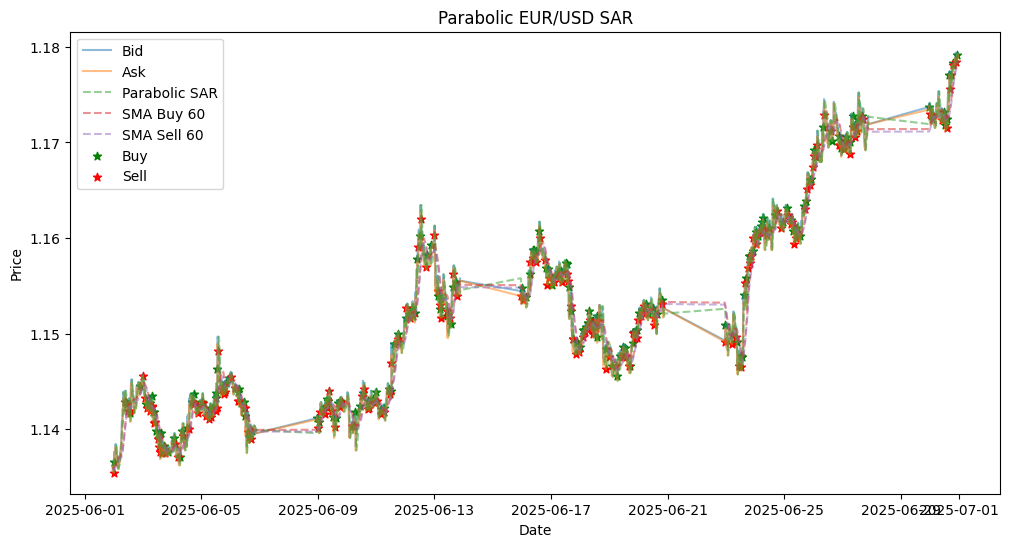

In [17]:
forexStrat(euroUsd, '2025-06-10', '2025-06-12')
forexStrat(euroUsd, '2025-06-02', '2025-06-03')
forexStrat(euroUsd, '2025-06-01', '2025-07-01')



In [19]:
def plot_future(data, smaPeriod, ticker):
   plt.figure(figsize=(12, 6))
   plt.plot(data['High'], label='Bid', alpha=0.5)
   plt.plot(data['Low'], label='Ask', alpha=0.5)

   plt.plot(data['SAR'], label='Parabolic SAR', linestyle='dashed', alpha=0.5)
   plt.plot(data['SMABuy'], label='SMA Buy '+ smaPeriod, linestyle='dashed', alpha=0.5)
   plt.plot(data['SMASell'], label='SMA Sell '+ smaPeriod, linestyle='dashed', alpha=0.5)
   plt.scatter(data[data['Position'] == 1].index, data['High'][data['Position'] == 1], marker='*', color='g', label='Buy')
   plt.scatter(data[data['Position'] == -1].index, data['Low'][data['Position'] == -1], marker='*', color='r', label='Sell')


    
   plt.title('Parabolic SAR ' + ticker)
   plt.xlabel('Date')
   plt.ylabel('Price')
   plt.legend()
   plt.show()

In [24]:
def futureStrat(price_data, startDate, endDate, ticker):
    size = price_data['High'].size
    high = np.zeros(size)
    low = np.zeros(size)
    signal = np.zeros(size)
    position = np.zeros(size)
    smaPeriod = 60
    stopLoss = 1.5
    profitObjective = 1
    initial = 0
    buyPosition = 0
    totalCash = 0
    hasBought = False
    hasSold = False
    numberTrades = 0
    numberProfitableTrades = 0
    buySarDirection = 0
    firstBuy = True
    stockAmount = 1
    nbStop = 0
    
    for x in range(size):
       low[x]=price_data['Low'].to_numpy()[x][0]
       high[x]=price_data['High'].to_numpy()[x][0]

    smaBuy = talib.SMA(high, timeperiod=smaPeriod)
    smaSell = talib.SMA(low, timeperiod=smaPeriod)

    price_data['SMABuy'] = smaBuy
    price_data['SMASell'] = smaSell
    
    price_data = price_data.loc[startDate:]
    price_data = price_data.loc[:endDate]

    size = price_data['High'].size
    high = np.zeros(size)
    low = np.zeros(size)
    signal = np.zeros(size)
    position = np.zeros(size)
    smaBuy = np.zeros(size)
    smaSell = np.zeros(size)
    

    for x in range(size):
       high[x]=price_data['High'].to_numpy()[x][0]
       low[x]=price_data['Low'].to_numpy()[x][0]
       smaBuy[x]=price_data['SMABuy'].iloc[x]
       smaSell[x]=price_data['SMASell'].iloc[x]

    
    #we buy the 'High' and sell the 'Low'

    sarResult = talib.SAR(high, low, acceleration=0.02, maximum=0.2)
    sarDirection = np.sign(np.diff(sarResult))
    smaBuyDirection = np.sign(np.diff(smaBuy))
    smaSellDirection = np.sign(np.diff(smaSell))

    for x in range(size):
        if x == 0 or x == size -1:
            continue

        if hasBought:
            if  sarDirection[x] <= 0 or x == size -1:
                position[x] = -1
                hasBought = False
                totalCash += low[x]
                numberTrades+=1
                print('at ' + str(price_data.index[x]) + ' We sell position of price ' + str(low[x]))
                margin = low[x] - buyPosition
                print('we do a margin of ' + str(margin))
                buyPosition = 0
                if margin > 0:
                    numberProfitableTrades+=1
            elif buyPosition - low[x] >= stopLoss or low[x] - buyPosition >= profitObjective: #stop loss
                nbStop+=1
                position[x] = -1
                hasBought = False
                numberTrades+=1
                print('at ' + str(price_data.index[x]) + ' STOP LOSS: We sell position of price ' + str(low[x]))
                margin = low[x] - buyPosition
                print('we do a margin of ' + str(margin))
                buyPosition = 0
                if margin > 0:
                    numberProfitableTrades+=1

        if hasSold:
            if sarDirection[x] >= 0 or x == size -1:
                position[x] = 1
                hasSold = False 
                numberTrades+=1
                print('at ' + str(price_data.index[x]) + ' We buy position of price ' + str(high[x]))
                margin = sellPosition - high[x]
                print('we do a margin of ' + str(margin))
                sellPosition = 0
                if margin > 0:
                    numberProfitableTrades+=1

            elif high[x] - sellPosition >= stopLoss or sellPosition - high[x]>= profitObjective:  #stoploss  + profit objective
                nbStop+=1
                hasSold = False 
                position[x] = 1
                numberTrades+=1
                print('at ' + str(price_data.index[x]) + ' STOP  We buy position of price ' + str(high[x]))
                margin = sellPosition - high[x]
                print('we do a margin of ' + str(margin))
                sellPosition = 0
                if margin > 0:
                    numberProfitableTrades+=1
        elif smaBuyDirection[x] > 0: #wants to buy
                if x < size-1 and high[x] > smaBuy[x] and sarResult[x-1] >= high[x-1] and sarResult[x] < high[x]:
                    hasBought = True;
                    buyPosition = high[x]
                    position[x] = 1
                    print('at ' + str(price_data.index[x]) + ' We buy position of price ' + str(high[x]))
        elif smaSellDirection[x] < 0: #wants to sell
            if x < size-1 and low[x] < smaSell[x] and sarResult[x-1] < low[x-1] and sarResult[x] >= low[x]:
                hasSold = True;
                sellPosition = low[x]
                position[x] = -1
                print('at ' + str(price_data.index[x]) + ' We sell position of price ' + str(low[x]))        
        
            
    price_data['Signal'] = signal
    price_data['SAR'] = sarResult
    price_data['Position'] = position;


   # price_data = price_data.loc['2025-06-01':]
  #  price_data = price_data.loc[:'2025-06-05']

   
    plot_future(price_data, str(smaPeriod), ' '+ ticker)
    print('profitable trades ' + str(numberProfitableTrades) +' total '  + str(numberTrades))
    print('stop losses ', nbStop)

    

C:\Users\alexi\AppData\Local\Temp\ipykernel_13876\989039489.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, interval=intervalOverride, keepna=False)
[*********************100%***********************]  1 of 1 completed


at 2025-06-02 01:35:00+00:00 We buy position of price 2371.25
at 2025-06-02 02:40:00+00:00 STOP LOSS: We sell position of price 2373.0
we do a margin of 1.75
at 2025-06-02 04:10:00+00:00 We sell position of price 2364.75
at 2025-06-02 04:20:00+00:00 STOP  We buy position of price 2363.5
we do a margin of 1.25
at 2025-06-02 14:00:00+00:00 We buy position of price 2392.0
at 2025-06-02 14:20:00+00:00 STOP LOSS: We sell position of price 2394.5
we do a margin of 2.5
at 2025-06-03 08:45:00+00:00 We sell position of price 2371.25
at 2025-06-03 08:50:00+00:00 STOP  We buy position of price 2377.5
we do a margin of -6.25
at 2025-06-03 12:35:00+00:00 We buy position of price 2387.0
at 2025-06-03 12:45:00+00:00 STOP LOSS: We sell position of price 2383.5
we do a margin of -3.5
at 2025-06-03 12:55:00+00:00 We sell position of price 2376.75
at 2025-06-03 13:00:00+00:00 STOP  We buy position of price 2383.5
we do a margin of -6.75
at 2025-06-03 13:15:00+00:00 We buy position of price 2388.25
at 202

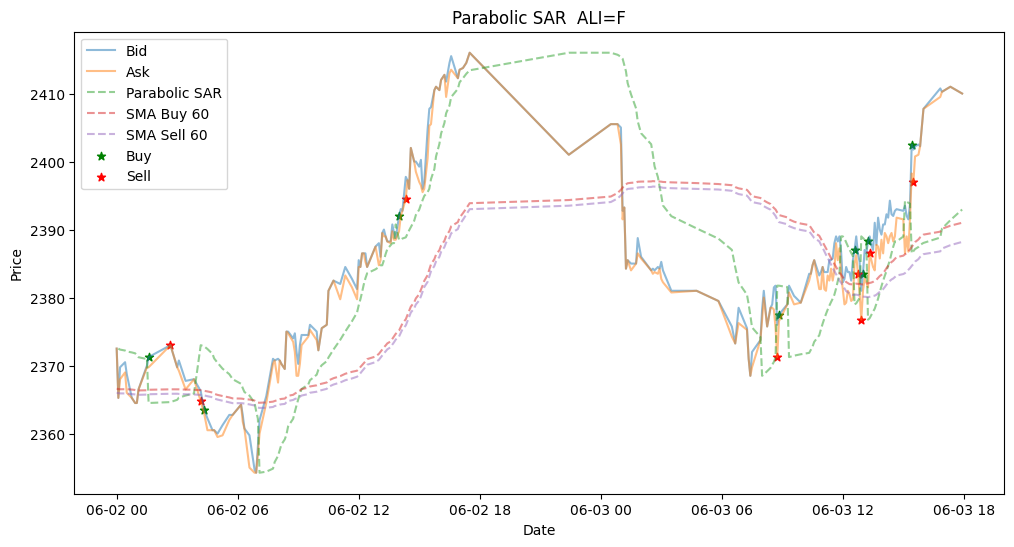

profitable trades 3 total 8
stop losses  8
at 2025-06-02 01:35:00+00:00 We buy position of price 2371.25
at 2025-06-02 02:40:00+00:00 STOP LOSS: We sell position of price 2373.0
we do a margin of 1.75
at 2025-06-02 04:10:00+00:00 We sell position of price 2364.75
at 2025-06-02 04:20:00+00:00 STOP  We buy position of price 2363.5
we do a margin of 1.25
at 2025-06-02 14:00:00+00:00 We buy position of price 2392.0
at 2025-06-02 14:20:00+00:00 STOP LOSS: We sell position of price 2394.5
we do a margin of 2.5
at 2025-06-03 08:45:00+00:00 We sell position of price 2371.25
at 2025-06-03 08:50:00+00:00 STOP  We buy position of price 2377.5
we do a margin of -6.25
at 2025-06-03 12:35:00+00:00 We buy position of price 2387.0
at 2025-06-03 12:45:00+00:00 STOP LOSS: We sell position of price 2383.5
we do a margin of -3.5
at 2025-06-03 12:55:00+00:00 We sell position of price 2376.75
at 2025-06-03 13:00:00+00:00 STOP  We buy position of price 2383.5
we do a margin of -6.75
at 2025-06-03 13:15:00+00

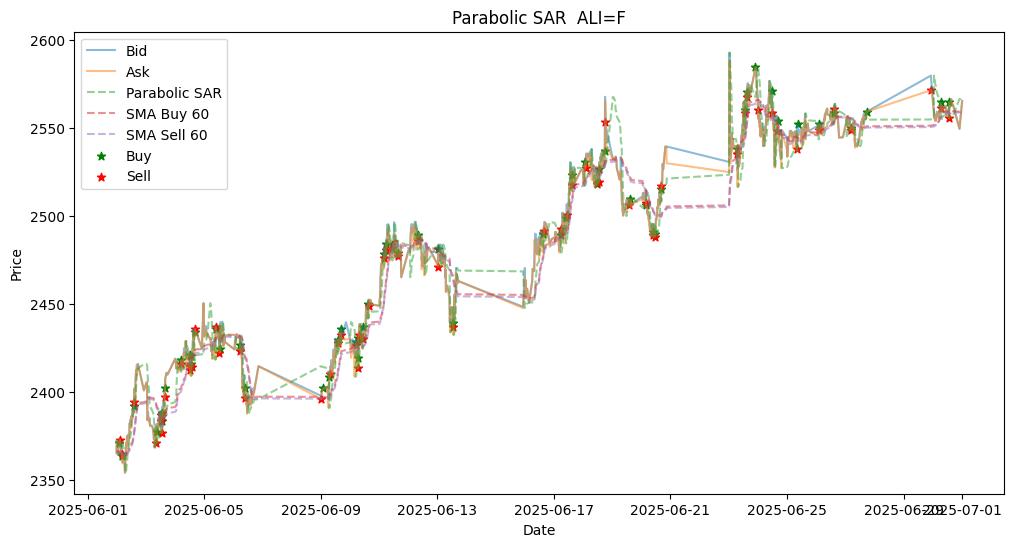

C:\Users\alexi\AppData\Local\Temp\ipykernel_13876\989039489.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, interval=intervalOverride, keepna=False)
[*********************100%***********************]  1 of 1 completed

profitable trades 16 total 59
stop losses  54


at 2025-06-02 05:05:00+00:00 We buy position of price 65.48999786376953
at 2025-06-02 07:35:00+00:00 We sell position of price 66.0999984741211
we do a margin of 0.6100006103515625
at 2025-06-02 07:50:00+00:00 We buy position of price 68.30000305175781
at 2025-06-02 07:55:00+00:00 STOP LOSS: We sell position of price 66.1500015258789
we do a margin of -2.1500015258789062
at 2025-06-02 08:50:00+00:00 We buy position of price 68.02999877929688
at 2025-06-02 08:55:00+00:00 We sell position of price 66.12999725341797
we do a margin of -1.9000015258789062
at 2025-06-02 11:25:00+00:00 We buy position of price 68.18000030517578
at 2025-06-02 11:30:00+00:00 STOP LOSS: We sell position of price 66.33999633789062
we do a margin of -1.8400039672851562
at 2025-06-02 14:30:00+00:00 We buy position of price 66.45999908447266
at 2025-06-02 15:10:00+00:00 We sell position of price 66.5
we do a margin of 0.04000091552734375
at 2025-06-02 17:00:00+00:00 We buy position of price 66.54000091552734
at 2025

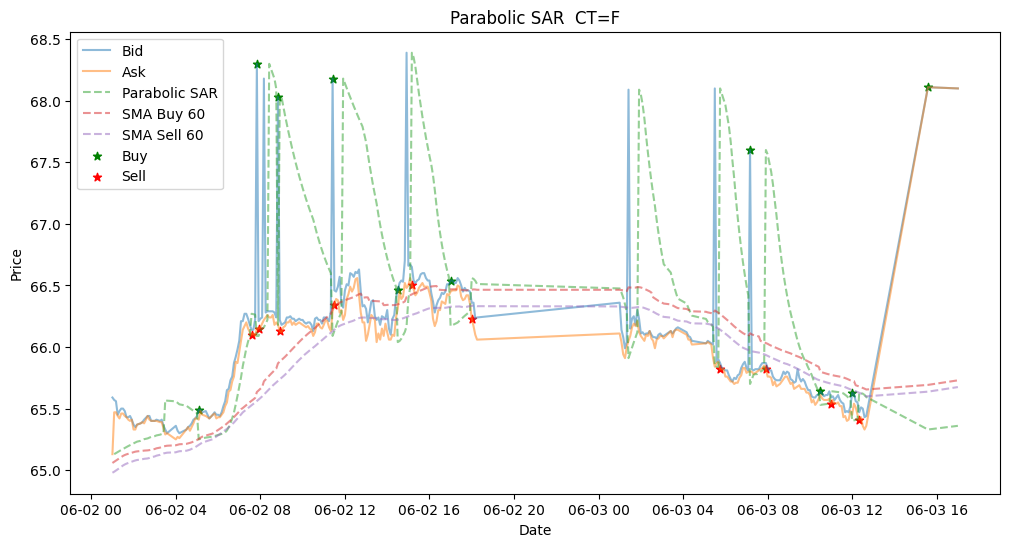

profitable trades 3 total 10
stop losses  2
at 2025-06-02 05:05:00+00:00 We buy position of price 65.48999786376953
at 2025-06-02 07:35:00+00:00 We sell position of price 66.0999984741211
we do a margin of 0.6100006103515625
at 2025-06-02 07:50:00+00:00 We buy position of price 68.30000305175781
at 2025-06-02 07:55:00+00:00 STOP LOSS: We sell position of price 66.1500015258789
we do a margin of -2.1500015258789062
at 2025-06-02 08:50:00+00:00 We buy position of price 68.02999877929688
at 2025-06-02 08:55:00+00:00 We sell position of price 66.12999725341797
we do a margin of -1.9000015258789062
at 2025-06-02 11:25:00+00:00 We buy position of price 68.18000030517578
at 2025-06-02 11:30:00+00:00 STOP LOSS: We sell position of price 66.33999633789062
we do a margin of -1.8400039672851562
at 2025-06-02 14:30:00+00:00 We buy position of price 66.45999908447266
at 2025-06-02 15:10:00+00:00 We sell position of price 66.5
we do a margin of 0.04000091552734375
at 2025-06-02 17:00:00+00:00 We buy

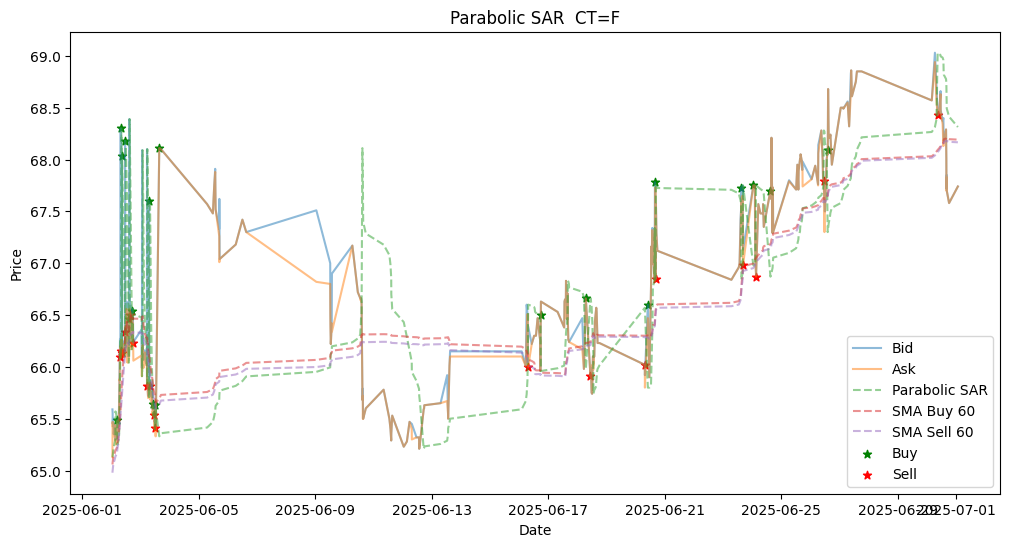

profitable trades 5 total 18
stop losses  2


In [25]:
ticker = 'ALI=F'
start_date = '2025-05-25'
end_date = '2025-07-01'
alu = get_price_data(ticker, start_date, end_date, '5m')
futureStrat(alu, '2025-06-02', '2025-06-3', ticker)
futureStrat(alu, '2025-06-01', '2025-07-1', ticker)


ticker = 'CT=F'
start_date = '2025-05-25'
end_date = '2025-07-01'
coton = get_price_data(ticker, start_date, end_date, '5m')
futureStrat(coton, '2025-06-02', '2025-06-03', ticker)


futureStrat(coton, '2025-06-01', '2025-07-01', ticker)


